# 皮肤癌图像分类：准确率>85%(仅训练四个周期）

本实验基于pytorch,对[kaggle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000) 上的一万多张皮肤癌图像进行学习和分类。该图片的标签分为7个等级，如下：

* 'nv': 'Melanocytic nevi',黑素细胞痣
* 'mel': 'meldermatofibroma',mel症
* 'bkl': 'Benign keratosis-like lesions ',良性keratosis-like病变
* 'bcc': 'Basal cell carcinoma',基底细胞癌
* 'akiec': 'Actinic keratoses',日光性角化症
* 'vasc': 'Vascular lesions',脉管疾病
* 'df': 'Dermatofibroma'皮肤纤维瘤

本例将使用Densenet-121进行训练，由于GPU资源限制，我们仅训练了4个周期，准确率就达到了85%。

首先，输入相关的库。

In [34]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

print(os.listdir("../input/skin-cancer-mnist-ham10000"))


['ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv']


## 第一步：数据分析与预处理

获取所有图像数据路径，将ham10000_metada .csv中的行信息与其对应的图像匹配。

In [35]:
data_dir = '../input/skin-cancer-mnist-ham10000'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
#连接两个或更多的路径名组件
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
#os.path.splitext(“文件路径”)    分离文件名与扩展名
#os.path.basename(x):返回path最后的文件名
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

此函数用于计算整个数据集的平均值和标准偏差，用于输入的标准化。

In [36]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 200, 200
    imgs = []
    means, stdevs = [], []

    #Tqdm 是一个快速，可扩展的Python进度条，可以在 Python 长循环中添加一个进度提示信息，用户只需要封装任意的迭代器 tqdm(iterator)。
    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)
    
    
    imgs = np.array(imgs,dtype=np.float32)/255.0
    #normalize the image from 0-255 to 0-1

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

        
    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs    

返回RGB通道的平均值和std

In [37]:
norm_mean,norm_std = compute_img_mean_std(all_image_path)

100%|██████████| 20030/20030 [03:41<00:00, 90.53it/s] 


normMean = [0.62485343, 0.62214255, 0.620066]
normStd = [0.17797484, 0.1801317, 0.18257397]


在原始数据aframe中添加三列:path(图像路径)、cell_type(全称)、cell_type_idx(单元格类型的对应索引，作为图像标签)

In [38]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
#pd.categorical.codes:得到原始数据的对应的序号列表
df_original.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2


In [39]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [40]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/HAM10000_i...,Benign keratosis-like lesions,2,duplicated


In [41]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [42]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [43]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [44]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [45]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [46]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [47]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

从以上每个类别的统计数据可以看出，训练数据存在严重的等级失衡。为了解决这个问题，我们可以从两个方面入手，一个是均衡采样，另一个是可以用来缓解训练中类别不平衡的损失函数，例如facal loss

In [48]:
# Copy fewer class to balance the number of 7 classes
#把对应标签的样本相应的复制15,10.。。。倍
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

一开始，我将数据分为训练集、验证集和测试集三部分，由于数据量小，在实践中没有进一步对验证集数据进行划分。

In [49]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

## 第二步：建立模型

In [50]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
#如果feature_extract = False，则对模型进行微调，并更新所有模型参数
#如果feature_extract = True，则仅更新最后一层参数，其余参数保持不变.def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [51]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    
    if model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        #pretrained：直接加载pre-train模型中预先训练好的参数
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)#修改最后一层分类器个数

        input_size = 224
        
   
        
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

考虑到训练数据有限，我们使用ImageNet预训练模型进行微调。这样可以加快模型的收敛速度，提高精度。

In [52]:
# densenet
model_name = 'densenet'
num_classes = 7
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

In [53]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [54]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [55]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

In [56]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

## 第三步：模型训练

In [57]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [58]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        #torch.Size([32, 3, 224, 224]) :32批次，3通道，及输入尺寸
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        #在torch中的Variable就是一个存放会变化的值的地理位置，里面的值会不断变化
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        #torch.Size([32, 7])
        #1所对应的是最大可能性的标签
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        #eq() 判断预测和标签是否相等，再求和，平均，计算每一个批次32张图的准确率
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
        #每100批次打印
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg


In [59]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0) #
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())
    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [60]:
epoch_num = 4
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1124], [train loss 1.24811], [train acc 0.54219]
[epoch 1], [iter 200 / 1124], [train loss 1.12128], [train acc 0.58516]
[epoch 1], [iter 300 / 1124], [train loss 1.04036], [train acc 0.61500]
[epoch 1], [iter 400 / 1124], [train loss 0.98004], [train acc 0.63492]
[epoch 1], [iter 500 / 1124], [train loss 0.93528], [train acc 0.65144]
[epoch 1], [iter 600 / 1124], [train loss 0.89797], [train acc 0.66609]
[epoch 1], [iter 700 / 1124], [train loss 0.87116], [train acc 0.67558]
[epoch 1], [iter 800 / 1124], [train loss 0.84955], [train acc 0.68371]
[epoch 1], [iter 900 / 1124], [train loss 0.83332], [train acc 0.68990]
[epoch 1], [iter 1000 / 1124], [train loss 0.81478], [train acc 0.69650]
[epoch 1], [iter 1100 / 1124], [train loss 0.79827], [train acc 0.70196]
------------------------------------------------------------
[epoch 1], [val loss 0.43331], [val acc 0.86137]
------------------------------------------------------------
***********************************

## 模型评估

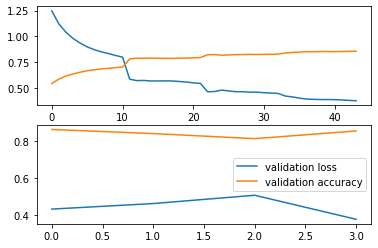

In [61]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

打印多类别预测的混淆矩阵

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    这个函数打印并绘制混淆矩阵。
    可以通过设置‘normalize=True’来应用标准化.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

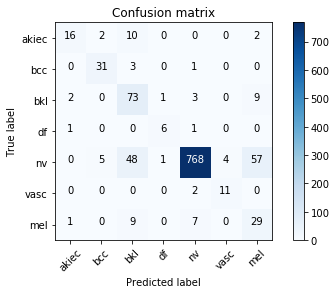

In [63]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
#横坐标是真实值，纵坐标是预测值

# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)



计算各个分类类别的报告

In [64]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.80      0.53      0.64        30
         bcc       0.82      0.89      0.85        35
         bkl       0.51      0.83      0.63        88
          df       0.75      0.75      0.75         8
          nv       0.98      0.87      0.92       883
        vasc       0.73      0.85      0.79        13
         mel       0.30      0.63      0.41        46

    accuracy                           0.85      1103
   macro avg       0.70      0.76      0.71      1103
weighted avg       0.90      0.85      0.86      1103



分类不正确的占比：

Text(0, 0.5, 'Fraction classified incorrectly')

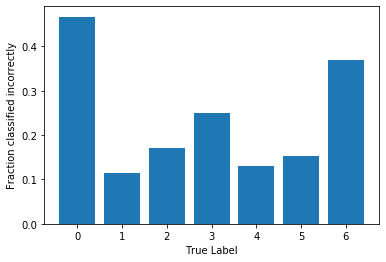

In [65]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

## 结论

使用Densenet-121时，验证集上7个类的平均准确率在4个epoch内可以达到85%。我们还计算了所有类别的混淆矩阵和每个类别的F1-score，这是一个更综合的指标，可以同时考虑分类模型的精度和召回率。我们的模型在F1-score指标上可以达到86%以上。

由于时间有限，我们没有花太多时间在模型训练上。通过增加训练时间，调整模型超参数，尝试不同的网络，可以进一步提高模型的性能。